安裝套件

In [2]:
import sys 
!{sys.executable} -m pip install keras

# 匯入套件

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

# 讀取資料(訓練資料)

In [48]:
train = pd.read_csv("台指數/台灣加權指數2014-2018.csv")
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,8618.599609,8632.809570,8587.540039,8612.540039,8612.507813,2537600.0
1,2014-01-03,8584.740234,8584.740234,8537.860352,8546.540039,8546.507813,2539700.0
2,2014-01-06,8553.000000,8568.240234,8488.639648,8500.009766,8499.977539,2640100.0
3,2014-01-07,8515.360352,8547.190430,8512.299805,8512.299805,8512.267578,2598900.0
4,2014-01-08,8548.610352,8587.080078,8548.610352,8556.009766,8555.977539,3206300.0


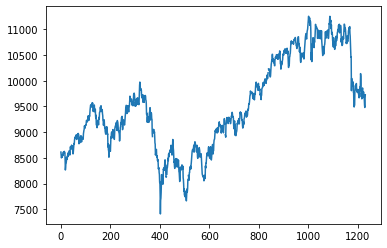

In [49]:
dataset = pd.read_csv('台指數/台灣加權指數2014-2018.csv', usecols=[4], engine='python')
plt.plot(dataset)
plt.show()

In [50]:
dataset.head()

,Close
0,8612.540039
1,8546.540039
2,8500.009766
3,8512.299805
4,8556.009766


除了資料提供的Features(Open, High, Low, Close, Adj Close, Volume)以外，可以自己增加Features，Ex:星期幾、幾月、幾號...。

In [51]:
def augFeatures(train):
    train["Date"] = pd.to_datetime(train["Date"])
    train["year"] = train["Date"].dt.year
    train["month"] = train["Date"].dt.month
    train["date"] = train["Date"].dt.day
    train["day"] = train["Date"].dt.dayofweek
    return train

In [52]:
# Augment the features (year, month, date, day)
train_Aug = augFeatures(train)
train_Aug.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,date,day
0,2014-01-02,8618.599609,8632.809570,8587.540039,8612.540039,8612.507813,2537600.0,2014,1,2,3
1,2014-01-03,8584.740234,8584.740234,8537.860352,8546.540039,8546.507813,2539700.0,2014,1,3,4
2,2014-01-06,8553.000000,8568.240234,8488.639648,8500.009766,8499.977539,2640100.0,2014,1,6,0
3,2014-01-07,8515.360352,8547.190430,8512.299805,8512.299805,8512.267578,2598900.0,2014,1,7,1
4,2014-01-08,8548.610352,8587.080078,8548.610352,8556.009766,8555.977539,3206300.0,2014,1,8,2
5,2014-01-09,8555.799805,8569.110352,8506.019531,8514.679688,8514.647461,3819600.0,2014,1,9,3
6,2014-01-10,8559.179688,8559.179688,8521.500000,8529.349609,8529.317383,2730100.0,2014,1,10,4
7,2014-01-13,8587.490234,8607.230469,8558.959961,8566.200195,8566.167969,2662700.0,2014,1,13,0
8,2014-01-14,8545.459961,8568.309570,8523.459961,8548.139648,8548.107422,2289900.0,2014,1,14,1
9,2014-01-15,8567.809570,8619.559570,8567.809570,8602.549805,8602.517578,2869000.0,2014,1,15,2


In [5]:
def normalize(train):
    train = train.drop(["Date"], axis=1)
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

In [6]:
# Normalization
train_norm = normalize(train_Aug)
train_norm.head(10)

,Open,High,Low,Close,Adj Close,Volume,year,month,date,day
0,-0.286975,-0.286072,-0.269521,-0.267662,-0.267662,-0.149288,-0.736364,0.474197,0.030168,-0.485859
1,-0.288036,-0.298464,-0.275044,-0.279102,-0.279102,-0.114509,-0.736364,0.474197,0.063502,-0.235859
2,-0.294288,-0.293780,-0.271715,-0.268382,-0.268382,-0.126621,-0.736364,0.474197,0.096835,0.014141
3,-0.292816,-0.301132,-0.282200,-0.286478,-0.286478,-0.137200,-0.736364,0.474197,0.130168,0.264141
4,-0.306945,-0.311298,-0.294493,-0.286120,-0.286120,-0.089292,-0.736364,0.474197,0.163502,0.514141
5,-0.307376,-0.315711,-0.289794,-0.292275,-0.292275,-0.175375,-0.736364,0.474197,0.263502,-0.485859
6,-0.322652,-0.333228,-0.312342,-0.311023,-0.311023,-0.166377,-0.736364,0.474197,0.296835,-0.235859
7,-0.325261,-0.327543,-0.313310,-0.319031,-0.319031,-0.185844,-0.736364,0.474197,0.330168,0.014141
8,-0.323477,-0.313589,-0.299584,-0.291965,-0.291965,-0.159929,-0.736364,0.474197,0.363502,0.264141
9,-0.306771,-0.303628,-0.286858,-0.277672,-0.277672,-0.172163,-0.736364,0.474197,0.396835,0.514141


In [7]:
#建立訓練資料
def buildTrain(train, pastDay=10, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Adj Close"]))
    return np.array(X_train), np.array(Y_train)

In [8]:
# build Data, use last 10 days to predict next 1 day
X_train, Y_train = buildTrain(train_norm, 10, 1)

In [9]:
#將Training Data(訓練資料)取一部份當作Validation Data(驗證資料)
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [10]:
# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)


In [11]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [22]:
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# setting the last 10 days and next 1 day 
X_train, Y_train = buildTrain(train_norm, 10, 1)
#X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_val, Y_val), callbacks=[callback])
#epoch、batch_size、learning rate

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5/5 [==============================] - 0s 52ms/step - loss: 0.0260 - val_loss: 0.0314
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0238
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0161
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0103
Epoch 5/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 6/500
5/5 [===============

5/5 [==============================] - 0s 4ms/step - loss: 4.5055e-04 - val_loss: 4.8848e-04
Epoch 151/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4875e-04 - val_loss: 5.0501e-04
Epoch 152/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4781e-04 - val_loss: 5.1529e-04
Epoch 153/500
5/5 [==============================] - 0s 4ms/step - loss: 4.5153e-04 - val_loss: 5.1142e-04
Epoch 154/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4461e-04 - val_loss: 5.0407e-04
Epoch 155/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4542e-04 - val_loss: 4.9247e-04
Epoch 156/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4134e-04 - val_loss: 4.8725e-04
Epoch 157/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4332e-04 - val_loss: 4.8624e-04
Epoch 158/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4027e-04 - val_loss: 4.9079e-04
Epoch 159/500
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 3.5367e-04 - val_loss: 6.2771e-04
Epoch 303/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5505e-04 - val_loss: 6.1033e-04
Epoch 304/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5868e-04 - val_loss: 5.8204e-04
Epoch 305/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5850e-04 - val_loss: 5.9744e-04
Epoch 306/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5463e-04 - val_loss: 5.7085e-04
Epoch 307/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5951e-04 - val_loss: 5.7240e-04
Epoch 308/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5598e-04 - val_loss: 6.6535e-04
Epoch 309/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5185e-04 - val_loss: 6.2710e-04
Epoch 310/500
5/5 [==============================] - 0s 4ms/step - loss: 3.5055e-04 - val_loss: 6.1563e-04
Epoch 311/500
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 3.0672e-04 - val_loss: 5.1999e-04
Epoch 455/500
5/5 [==============================] - 0s 4ms/step - loss: 3.0669e-04 - val_loss: 5.2520e-04
Epoch 456/500
5/5 [==============================] - 0s 4ms/step - loss: 3.0654e-04 - val_loss: 5.3009e-04
Epoch 457/500
5/5 [==============================] - 0s 4ms/step - loss: 3.1086e-04 - val_loss: 5.4002e-04
Epoch 458/500
5/5 [==============================] - 0s 4ms/step - loss: 3.0939e-04 - val_loss: 5.4915e-04
Epoch 459/500
5/5 [==============================] - 0s 4ms/step - loss: 3.0684e-04 - val_loss: 5.4287e-04
Epoch 460/500
5/5 [==============================] - 0s 4ms/step - loss: 3.1720e-04 - val_loss: 5.5527e-04
Epoch 461/500
5/5 [==============================] - 0s 4ms/step - loss: 3.1642e-04 - val_loss: 5.4548e-04
Epoch 462/500
5/5 [==============================] - 0s 4ms/step - loss: 3.0951e-04 - val_loss: 5.4856e-04
Epoch 463/500
5/5 [==============================] 

# 取「close」欄位值

In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
%matplotlib inline

#載入資料
dataset_train = pd.read_csv("台指數/台灣加權指數2014-2018.csv")
training_set = dataset_train.iloc[: ,4:5].values
#training_set = dataset_train.iloc[: ,1:2].values
training_set

array([[8612.540039],
       [8546.540039],
       [8500.009766],
       ...,
       [9478.990234],
       [9641.55957 ],
       [9727.410156]])

In [2]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

#做 Normalization，將資料壓縮在 [0,1] 之間
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [3]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, 1231):  # 1231 是訓練集總數 / 2014~2018總天數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
print(X_train, y_train)

[[0.31284725 0.29567214 0.28356362 ... 0.38907094 0.38467043 0.38152176]
 [0.29567214 0.28356362 0.28676185 ... 0.38467043 0.38152176 0.38459496]
 [0.28356362 0.28676185 0.29813644 ... 0.38152176 0.38459496 0.39560793]
 ...
 [0.91321874 0.89872673 0.86098566 ... 0.58976462 0.58014403 0.55083956]
 [0.89872673 0.86098566 0.80847406 ... 0.58014403 0.55083956 0.53832265]
 [0.86098566 0.80847406 0.79255054 ... 0.55083956 0.53832265 0.58062789]] [0.38459496 0.39560793 0.40016956 ... 0.53832265 0.58062789 0.60296869]


因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]

In [4]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)

[[[0.31284725]
  [0.29567214]
  [0.28356362]
  ...
  [0.38907094]
  [0.38467043]
  [0.38152176]]

 [[0.29567214]
  [0.28356362]
  [0.28676185]
  ...
  [0.38467043]
  [0.38152176]
  [0.38459496]]

 [[0.28356362]
  [0.28676185]
  [0.29813644]
  ...
  [0.38152176]
  [0.38459496]
  [0.39560793]]

 ...

 [[0.91321874]
  [0.89872673]
  [0.86098566]
  ...
  [0.58976462]
  [0.58014403]
  [0.55083956]]

 [[0.89872673]
  [0.86098566]
  [0.80847406]
  ...
  [0.58014403]
  [0.55083956]
  [0.53832265]]

 [[0.86098566]
  [0.80847406]
  [0.79255054]
  ...
  [0.55083956]
  [0.53832265]
  [0.58062789]]]


In [25]:
# Import the Keras libraries and packages
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Initialising the RNN
keras.backend.clear_session()
regressor = Sequential()

# 搭建 LSTM layer:


units: 神經元的數目 (setting 50)

第一層的 LSTM Layer 記得要設定input_shape參數

In [26]:
input_shape = (X_train.shape[1], 1)
print(input_shape)

(60, 1)


搭配使用dropout，這裡設為 0.2(Float between 0 and 1)

由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [27]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

In [28]:
# Adding the output layer setting 1
regressor.add(Dense(units = 1))

# Compiling & Fitting LSTM model
optimizer: 選擇 Adam \\\\\\
loss: 使用 MSE

In [29]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 0s 10ms/step - loss: nan
Epoch 2/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 3/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 4/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 5/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 6/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 7/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 8/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 9/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 10/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 11/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 12/100
37/37 [==============================] - 0s 9ms/step - loss: nan
Epoch 13/100
37/37 [==============================] - 0s 9ms/step - loss

# 預測步驟

取測試集中 2019 年的股票資料（真實）

In [128]:
dataset_test = pd.read_csv('台指數/台灣加權指數2019-2020.csv', usecols=[4], engine='python')
dataset_test.values

array([[ 9554.139648],
       [ 9492.419922],
       [ 9382.509766],
       [ 9590.299805],
       [ 9563.599609],
       [ 9738.30957 ],
       [ 9720.69043 ],
       [ 9759.400391],
       [ 9708.219727],
       [ 9806.040039],
       [ 9763.80957 ],
       [ 9789.150391],
       [ 9836.05957 ],
       [ 9889.400391],
       [ 9894.660156],
       [ 9846.400391],
       [ 9877.120117],
       [ 9969.610352],
       [10013.330078],
       [ 9931.589844],
       [ 9932.259766],
       [10004.25    ],
       [10097.740234],
       [10090.580078],
       [10089.009766],
       [10064.780273],
       [10145.280273],
       [10152.259766],
       [10272.459961],
       [10319.530273],
       [10322.919922],
       [10390.929688],
       [10391.549805],
       [10389.169922],
       [10349.879883],
       [10305.259766],
       [10357.150391],
       [10311.679688],
       [10241.75    ],
       [10250.280273],
       [10343.330078],
       [10373.320313],
       [10348.650391],
       [104

In [118]:
dataset_test = pd.read_csv('台指數/台灣加權指數2019-2020.csv')
#real_stock_price = dataset_test.iloc[:, 4:5].values
real_stock_price = dataset_test.iloc[:, 1:2].values

取模型所預測的 2019 年股票資料（預測）

In [119]:
#dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0) #axis=0 直向合併
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling 標準化處理
inputs

array([[0.84846306],
       [0.79672603],
       [0.79581938],
       [0.74541634],
       [0.624758  ],
       [0.67141394],
       [0.6458232 ],
       [0.68682177],
       [0.66770088],
       [0.64254772],
       [0.64040688],
       [0.65114535],
       [0.61498657],
       [0.57532967],
       [0.56150457],
       [0.54715513],
       [0.54542041],
       [0.56639681],
       [0.6249205 ],
       [0.64043324],
       [0.63662037],
       [0.64489046],
       [0.62647968],
       [0.66324878],
       [0.65363472],
       [0.62350538],
       [0.60263927],
       [0.62164245],
       [0.62344781],
       [0.62671536],
       [0.62053647],
       [0.6188281 ],
       [0.59513176],
       [0.61368687],
       [0.60354847],
       [0.59027381],
       [0.60310577],
       [0.6149185 ],
       [0.66361573],
       [0.64772836],
       [0.66868352],
       [0.70568856],
       [0.66678911],
       [0.63484649],
       [0.60061896],
       [0.60153866],
       [0.58548879],
       [0.606

In [109]:
X_test = []
for i in range(60, 70):  # timesteps一樣60； 70 = 先前的60天資料 + 預測2019年的10天資料
    X_test.append(inputs[i-60:i ,0])
    print(X_test.append(inputs[i-60:i ,0]))

None
None
None
None
None
None
None
None
None
None


In [104]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

開始預測10天股價

In [97]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [90]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # to get the original scale

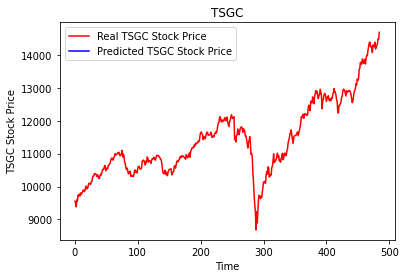

In [88]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real TSGC Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TSGC Stock Price')  # 藍線表示預測股價
plt.title('TSGC')
plt.xlabel('Time')
plt.ylabel('TSGC Stock Price')
plt.legend()
plt.show()